# Classifying Pablo Picasso Arts from other Artists.

Artist identification of fine art paintings is a challenging problem primarily handled by art historians with extensive training and expertise. Many previous works have explored this problem by explicitly defining classification features.

Dataset Overview: In order to train a CNN to identify artists, i first obtain a large dataset of art compiled by Kaggle that is based on the WikiArt dataset [13]. This dataset contains roughly 100,000 paintings by 2,300 artists spanning a variety of time periods and styles.The images vary widely in size and shape. Every image is labeled with its artist in a separate .csv file. I have 500 paintings for Pablo Picasso out of 100,000 paintings from various artists. My project is to predict Pablo Picasso paintings.

We'll begin these exercises with the most basic type of neural network and move into the more modern and complicated kinds. This will also work nicely to move through some of the features of Keras. 

In [57]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread, imshow
from skimage import transform
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from IPython.display import Image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

#### Art selection: 

The vast majority of artists in the full dataset have fewer than 50 paintings, so in order to ensure sufficient sample sizes for training networks we use only the artists with 300 or more paintings in the dataset. Therefore, our dataset consists of 13000 paintings from 50 artists from a wide variety of styles and time periods.

To get started we will load the necessary packages and write some functions to load the data into suitable forms for doing computation on them. This will load the images into numpy arrays that are in the shape (num_pics, channels, width, height).

In [35]:
# path to the saved folder from Kaggle and the number of pixels to use for height and width
#PATH = 'data/allimages'
PATH='Data/final_allimages' 
#PATH1='Data/test'
PIXELS = 64

def load_images(path):
    # read all of the image files in the directory
    names = [d for d in os.listdir(path) if d.endswith('.jpg')]
    
    print('Making dataset')
    # set up an empty numpy array for our images
    training_images = np.zeros((len(names), PIXELS, PIXELS, 3), dtype=np.float32)
    labels = []
    for i, n in enumerate(names):
        #print n
        img = imread(os.path.join(path, n))
        # skimage loads image as (height, width, channel) for RGB images channels = 3
        img = transform.resize(img, output_shape=(PIXELS, PIXELS , 3), preserve_range=True, mode='reflect')
        training_images[i,:,:,:] = img
        
        # check the label on the filename and encode the label into integers
        if n.split('_')[0] == 'Picasso':
            labels.append(1) #Labelling Pablo Picasso as 1 and rests as 0.
        else:
            labels.append(0)
            
    return training_images, np.asarray(labels)

X_train, y_train = load_images(PATH)
print(X_train.shape)
print(y_train.shape)
print('Done!')

Making dataset
(13039, 64, 64, 3)
(13039,)
Done!


Once we have the data in a suitable form we can check the images to make sure that they look ok. Also to make sure that we didn't mess up the indexing for the labels somehow. 

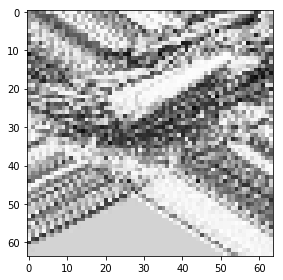

0


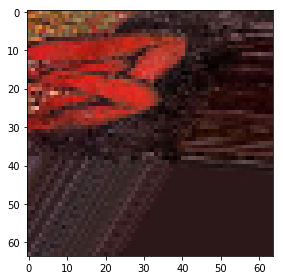

1


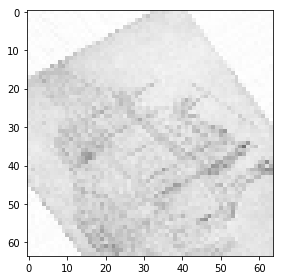

0


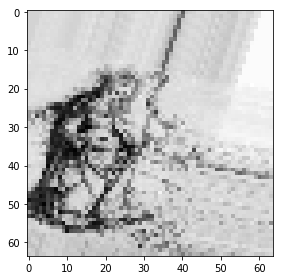

0


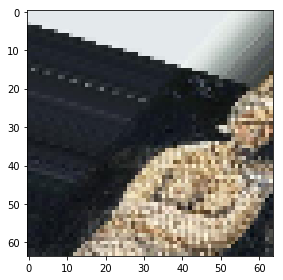

1


In [36]:
from random import randint
%matplotlib inline
from matplotlib import pyplot

def plot_sample(img):
    # we have to tranpose the image back to it's original shape
    # also for some reason imshow in skimage wants images to be float between 0-1 so we divide by it's max
    imshow(img / np.amax(img))
    pyplot.show(block=True)

# We'll pick 5 random images, plot them and print their labels
for _ in range(0,5):
    j = randint(0, X_train.shape[0])
    plot_sample(X_train[j])
    print(y_train[j])

Now we have our data in a suitable form we can start to train some models on it. 

Since we are going to go in order from simple neural network to modern neural network we will start with a simple linear model. To get a baseline we'll implement it in sklearn. Then do the same exact thing with Keras. 

In [37]:
X_train.shape

(13039, 64, 64, 3)

In [38]:
y_train[y_train==1].shape

(6532,)

In [39]:
y_train[y_train==0].shape

(6507,)

In [40]:
#I'll use sklearn to shuffle and split the data
X_train, y_train = shuffle(X_train, y_train)

# should give us some training images and some testing images to eval performance on
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=12)

In [41]:
X_train.shape

(10431, 64, 64, 3)

In [42]:
y_train[y_train==1].shape

(5215,)

In [43]:
y_train[y_train==0].shape

(5216,)

In [56]:
# have to reshape the images to flat, logistic regression can't handle tensors like ConvNets can
# save this value for that later
num_features = 3*PIXELS*PIXELS

logit = LogisticRegression()

logit.fit(X_train.reshape(len(X_train), num_features), y_train)

preds = logit.predict_proba(X_test.reshape(len(X_test), num_features))

roc_auc_score(y_test, preds[:,1])

0.60862480568999677

61% accuracy with logistic regression is not good enough. Trying some other classification model.

In [ ]:
classifier = [
    KNeighborsClassifier(2),
    #SVC(kernel='linear', C=0.025),
    SVC(kernel='rbf', gamma=2, C=1),
    SVC(kernel='poly', degree=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    DecisionTreeClassifier(criterion='entropy',min_samples_split=10),
    RandomForestClassifier(max_depth=5,n_estimators=10,max_features=1),
    AdaBoostClassifier(),
    GaussianNB()]

for clf in classifier:
    clf.fit(X_train.reshape(len(X_train), num_features), y_train)
    pred=clf.predict(X_test.reshape(len(X_test), num_features))
    print(" Accuracy_score:: " + str(roc_auc_score(y_test, preds[:,1])))

 Accuracy_score:: 0.60862480569


# Evaluating the model

In [ ]:
pd.crosstab(y_test, clf.predict(X_test.reshape(len(X_test), num_features)), rownames=['Actual'], colnames=['Predicted'])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, X_test.reshape(len(X_test), num_features))

Let's do some plotting to identify whether Picasso art features can be identified from other artists or not.

In [5]:
import cv2
#setup a standard image size; this will distort some images but will get everything into the same shape
STANDARD_SIZE = (128, 128)
def img_to_matrix(filename, verbose=False):
    """
    takes a filename and turns it into a numpy array of RGB pixels
    """
    #img = PImage.open(filename)
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if verbose==True:
        print ("changing size from %s to %s" % (str(img.size), str(STANDARD_SIZE)))
    #img = img.resize(STANDARD_SIZE)
    img=cv2.resize(img, STANDARD_SIZE)
    #img = list(img.getdata())
    #img = map(list, img)
    img = np.array(img)
    return img

def flatten_image(img):
    """
    takes in an (m, n) numpy array and flattens it 
    into an array of shape (1, m * n)
    """
    s = img.shape[0] * img.shape[1]
    #print(img.shape[0])
    #print(img.shape[1])
    #print(img.shape)
    img_wide = img.reshape(1, s)
    #print(img_wide[0])
    return img_wide[0]

In [6]:
#Checking one image

filename='images_copy/Albrecht_Durer_23.jpg'
img_gray=img_to_matrix(filename, verbose=True)
print("Gray Scale Image"  + str(img_gray))
#glcimg=glcm(img_gray)
#print('glc image' + str(glcimg))
img=flatten_image(img_gray)
print("Flatten Image" + str(img))
#img.size
#test_imgs.shape
#print(img)
#cv2.imshow('show',glcimg)

changing size from 85248 to (128, 128)
Gray Scale Image[[253 252 251 ..., 242 242 237]
 [253 252 251 ..., 244 242 239]
 [253 252 251 ..., 245 242 240]
 ..., 
 [254 251 249 ..., 244 242 241]
 [252 250 250 ..., 242 240 237]
 [252 250 250 ..., 241 235 241]]
Flatten Image[253 252 251 ..., 241 235 241]


In [7]:
#Nomalize the data

img_dir = "images_copy/"
images = [img_dir + f for f in os.listdir(img_dir)]

data = []
for image in images:
    img = img_to_matrix(image)
    img = flatten_image(img)
    #img = glcm(img)
    data.append(img)

data = np.array(data)
data

array([[187, 185, 185, ...,  93,  96,  94],
       [  0,   0,   2, ...,  46,  62,  62],
       [195, 179, 181, ..., 253, 251, 248],
       ..., 
       [155, 167, 157, ..., 207, 210, 205],
       [202, 204, 206, ..., 177, 158, 156],
       [160, 144, 139, ..., 158, 164, 156]], dtype=uint8)

In [8]:
### Lets have some Plotting to see whether we can classify Picasso from other Artists.

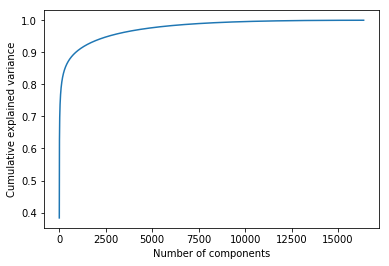

In [9]:
from sklearn.decomposition import PCA

pca = PCA().fit(data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
#plt.xlim(0,200,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [10]:
#Since 2500 components can explain more than 94% of the variance, we choose the number of the components to be 2500
sklearn_pca=PCA(n_components=2500)
X = sklearn_pca.fit_transform(data)

In [11]:
import os
test_images = pd.DataFrame(next(os.walk('images_copy'))[2], columns=['new_filename'])
test_images = test_images['new_filename'].apply(lambda x: x.replace(x.split('_')[-1],''))
test_images = test_images.apply(lambda x: x.replace('_', ' '))
test_images=test_images.ravel()
labels = [1 if 'Pablo Picasso' in f else 0 for f in test_images.tolist()]
y=pd.Series(labels)

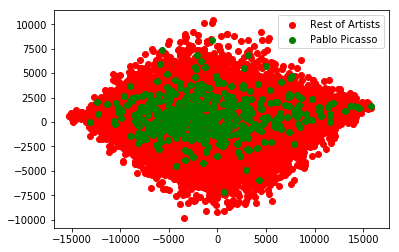

In [12]:
df = pd.DataFrame({"x": X[:, 0], "y": X[:, 1], "label":np.where(y==1, "Pablo Picasso", "Rest of Artists")})
colors = ["red", "green"]
for label, color in zip(df['label'].unique(), colors):
    mask = df['label']==label
    plt.scatter(df[mask]['x'], df[mask]['y'], c=color, label=label)
plt.legend()
plt.show()

Green stuff is for Pablo Picasso, so we can classify Picasso arts by some non-linear functions. We have some outliers due to similar kind of art style with some other artists for specific features.

Ok so that wasn't really interesting because it's a logistic regression from sklearn. But, it's essentially the same as the most basic type of neural network. So we'll implement the that type of neural network with a neural network library. The result should be the same.

In [54]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import SGD, Adam

# have to reshape the images to flat, logistic regression can't handle tensors like ConvNets can
# save this value for that later
num_features = 3*PIXELS*PIXELS

logit_input = Input(shape=(num_features,), name='Input', dtype='float32')
probs = Dense(1, activation='sigmoid')(logit_input)
model = Model(input=logit_input, output=probs)

adam = Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

model.fit(X_train.reshape(len(X_train), num_features), y_train)

preds = model.predict(X_test.reshape(len(X_test), num_features))

roc_auc_score(y_test, preds)

/Users/kausik/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("In..., outputs=Tensor("de...)`
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/1
10431/10431 [==============================] - 0s - loss: 7.9953 - acc: 0.5028     


0.50219468112574228

OK so that was pretty terrible. But logistic regression is not the right tool for an image recognition task. So lets actually implement some neural networks.

We'll first take the same response that the community had when it was pointed out that a perceptron couldn't solve XOR. The following code will produce a multilayer perceptron. 

### Convolutional Neural Networks

So now we'll get to the architectures that kick started the deep learning hype in 2012. Convolutional neural networks. This is a pretty tiny one compared to todays standards, but it should also run fine on a CPU. So it will be easy to play with on a laptop.

The right tool for an image classification job is a convnet, so let's try to train one on our data, as an initial baseline. Since we only have few examples, our number one concern should be overfitting. Overfitting happens when a model exposed to too few examples learns patterns that do not generalize to new data, i.e. when the model starts using irrelevant features for making predictions.

In [55]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten

cnn_input = Input(shape=(PIXELS, PIXELS, 3), name='Input', dtype='float32')

conv_1 = Conv2D(8, (3,3), activation='relu')(cnn_input)
pool_1 = MaxPooling2D(pool_size=(2,2))(conv_1)

conv_2 = Conv2D(16, (3,3), activation='relu')(pool_1)
pool_2 = MaxPooling2D(pool_size=(2,2))(conv_2)

flat = Flatten()(pool_2)

fc1 = Dense(32, activation='relu')(flat)
fc2 = Dense(32, activation='relu')(fc1)

probs = Dense(1, activation='sigmoid')(fc2)

model = Model(input=cnn_input, output=probs)
adam = Adam(lr=0.001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

model.fit(X_train, y_train)

preds = model.predict(X_test)

roc_auc_score(y_test, preds)

/Users/kausik/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("In..., outputs=Tensor("de...)`


Epoch 1/1
10431/10431 [==============================] - 16s - loss: 7.9720 - acc: 0.5000    


0.5

The performance was improved but with such a small dataset we can't train a larger more powerful network. If we try something more similar to a modern net we'll overfit like crazy and our test set performance will be terrible. 

In [83]:
cnn_input = Input(shape=(PIXELS, PIXELS, 3), name='Input', dtype='float32')

conv_1 = Conv2D(32, (3,3), activation='relu')(cnn_input)
pool_1 = MaxPooling2D(pool_size=(2,2))(conv_1)

conv_2 = Conv2D(64, (3,3), activation='relu')(pool_1)
pool_2 = MaxPooling2D(pool_size=(2,2))(conv_2)

flat = Flatten()(pool_2)

fc1 = Dense(32, activation='relu')(flat)
fc2 = Dense(32, activation='relu')(fc1)

probs = Dense(1, activation='sigmoid')(fc2)

model = Model(input=cnn_input, output=probs)
adam = Adam(lr=0.001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

history = model.fit(X_train, y_train)

preds = model.predict(X_test)

roc_auc_score(y_test, preds)

/Users/kausik/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("In..., outputs=Tensor("de...)`
  app.launch_new_instance()


Epoch 1/1
20312/20312 [==============================] - 103s - loss: 8.0114 - acc: 0.4974   


0.5

### Training loops and tricks.

When humans are classifying images we tend to be pretty invariant to random changes in the images. Meaning that we can still a dog from a cat if the images are rotated, have different lighting, are skewed in some way, or partially blocked or something like that.

We can attempt to get a neural network to be invariant to these changes as well by randomly perturbing the input to the network. The two strategies that you can use is to generate new data with random changes and append it to the original data or we can make small adjustments to each image as we are feeding it to the network. I tend to favor the second option because it requires less space on disk or in memory and it results in more random shifts than would be possible if you were to generate them ahead of time. If you have a dataset of millions of images and you are going to loop over them 100 times, generate 100 randomly changed copies of each image would be crazy. If you generate them on the fly then you are not limited to the memory of the computer.

This has become pretty standard practice when training ConvNets for image classification and I can't think of any reason not to use at least a very basic version of this. At the minimum I would recommend always using random translations and if your dataset is appropriate horizontal flipping. With translations you are helping your network learn to find useful patterns of features no matter where they appear in the image. With horizontal flipping you are able to make drastic changes to the input images at the pixel level while still keeping all of the distinguishing qualities of the image classes intact.

### Data augmentation in Keras

When doing these types of augmentations with Keras it's very simple because we can just use some built in functionality of the library. 

The right tool for an image classification job is a convnet, so let's try to train one on our data, as an initial baseline. Since we only have few examples, our number one concern should be overfitting. Overfitting happens when a model exposed to too few examples learns patterns that do not generalize to new data, i.e. when the model starts using irrelevant features for making predictions.

For instance, if you, as a human, only see three images of people who are lumberjacks, and three, images of people who are sailors, and among them only one lumberjack wears a cap, you might start thinking that wearing a cap is a sign of being a lumberjack as opposed to a sailor. You would then make a pretty lousy lumberjack/sailor classifier.

Data augmentation is one way to fight overfitting, but it isn't enough since our augmented samples are still highly correlated. Your main focus for fighting overfitting should be the entropic capacity of your model ­­how much information your model is allowed to store. A model that can store a lot of information has the potential to be more accurate by leveraging more features, but it is also more at risk to start storing irrelevant features. Meanwhile, a model that can only store a few features will have to focus on the most significant features found in the data, and these are more likely to be truly relevant and to generalize better.

There are different ways to modulate entropic capacity. The main one is the choice of the number of parameters in your model, i.e. the number of layers and the size of each layer. Another way is the use of weight regularization, such as L1 or L2 regularization, which consists in forcing model weights to taker smaller values.

In our case we will use a very small convnet with few layers and few filters per layer, alongside data augmentation and dropout. Dropout also helps reduce overfitting, by preventing a layer from seeing twice the exact same pattern, thus acting in a way analoguous to data augmentation (you could say that both dropout and data augmentation tend to disrupt random correlations occuring in your data).

In [67]:
def image_aug(image, path, type):

    img = load_img(path + '/' + image)   #This is a PIL Image
    X = img_to_array(img)   #This is the numpy array
    X = X.reshape((1,) + X.shape)
    
    datagen = ImageDataGenerator(
        rotation_range=90,
        width_shift_range=0.4,
        height_shift_range=0.4,
        shear_range=0.4,
        zoom_range=0.4,
        horizontal_flip=True,
        fill_mode='nearest')

    #os.makedirs('images_aug_' + type)

#The .flow() command below generates batches of randomly transformed images and saves the results to the 'preview/' directory.

    i = 0

    for batch in datagen.flow(X, batch_size=60, save_to_dir='images_aug_' + type, save_prefix='Picasso', save_format='jpg'):
        
        i +=1
        if i > 20:
            
            break #otherwise the generator would loop indefinitely

In [65]:
path = 'images/test/Pablo_Picasso'
os.makedirs('images_aug_test')

names = [d for d in os.listdir(path) if d.endswith('.jpg')]

for m in names:
    image_aug(m, 'images/test/Pablo_Picasso', 'test')

In [70]:
path = 'images_aug_train'
os.makedirs('images_aug_train1')
names = [d for d in os.listdir(path) if d.endswith('.jpg')]

for m in names:
    image_aug(m, 'images_aug_train', 'train1')

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 24

datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')


#this is a generator that will read pictures found in subfolders of images_final/train or test and indefinitely generate batches 
#of augmented image data.

train_generator = datagen.flow_from_directory(
         #'images/train',
          #'images_final/train',
         'images_final/train',
          target_size=(64,64),  #all images will be resized to 250 X 250
          batch_size=batch_size,
          class_mode='binary')  #since we use categorical_crossentropy loss, we need binary label
'''
#this is similar generator, for validation data
val_generator = val_datagen.flow_from_directory(
         #'images/test',
          'dataset/validation1',
          target_size=(250,250),  #all images will be resized to 250 X 250
          batch_size=batch_size,
          class_mode='categorical')  #since we use binary_crossentropy loss, we need binary label
'''
#this is similar generator, for test data
test_generator = datagen.flow_from_directory(
         #'images/test',
          #'images_final/test',
          'images_final/test',
          target_size=(64,64),  #all images will be resized to 250 X 250
          batch_size=batch_size,
          class_mode='binary')  #since we use binary_crossentropy loss, we need binary label



Using this datagenerater is also pretty simple. We just have to fit the datagen to our dataset so that it gets an idea about the sizes of the images and how many there are. Then we use the .flow() and fit_generator() functions from the datagenerator and model. 

rotation_range is a value in degrees (0­180), a range within which to randomly rotate pictures.

width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.

rescale is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0­255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor.

shear_range is for randomly applying shearing transformations.

zoom_range is for randomly zooming inside pictures.

horizontal_flip is for randomly flipping half of the images horizontally ­­relevant when there are no assumptions of horizontal assymetry (e.g. real­world pictures)

fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

In [44]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 24

datagen = ImageDataGenerator()
        

# Part-1: Basics of Convolutional Neural networks:

Neural Networks are essentially mathematical models to solve an optimization problem. They are made of neurons, the basic computation unit of neural networks. A neuron takes an input(say x), do some computation on it(say: multiply it with a variable w and adds another variable b ) to produce a value (say; z= wx+b). This value is passed to a non-linear function called activation function(f) to produce the final output(activation) of a neuron. There are many kinds of activation functions. One of the popular activation function is Sigmoid, which is:

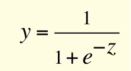


The neuron which uses sigmoid function as an activation function will be called Sigmoid neuron. Depending on the activation functions, neurons are named and there are many kinds of them like RELU, TanH etc(remember this). One neuron can be connected to multiple neurons, like this:

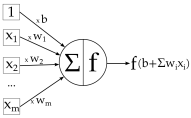


In this example, you can see that the weights are the property of the connection, i.e. each connection has a different weight value while bias is the property of the neuron. This is the complete picture of a sigmoid neuron which produces output y:

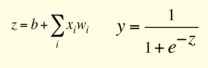


If you stack neurons in a single line, it’s called a  layer; which is the next building block of neural networks.

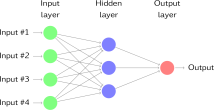

As you can see above, the neurons in green make 1 layer which is the first layer of the network through which input data is passed to the network. Similarly, the last layer is called output layer as shown in red. The layers in between input and output layer are called hidden layers. In this example, we have only 1 hidden layer shown in blue. The networks which have many hidden layers tend to be more accurate and are called deep network and hence machine learning algorithms which uses these deep networks are called deep learning.

In summary:

A ConvNet architecture is in the simplest case a list of Layers that transform the image volume into an output volume (e.g. holding the class scores)

There are a few distinct types of Layers (e.g. CONV/FC/RELU/POOL are by far the most popular)

Each Layer accepts an input 3D volume and transforms it to an output 3D volume through a differentiable function

Each Layer may or may not have parameters (e.g. CONV/FC do, RELU/POOL don’t)

Each Layer may or may not have additional hyperparameters (e.g. CONV/FC/POOL do, RELU doesn’t)


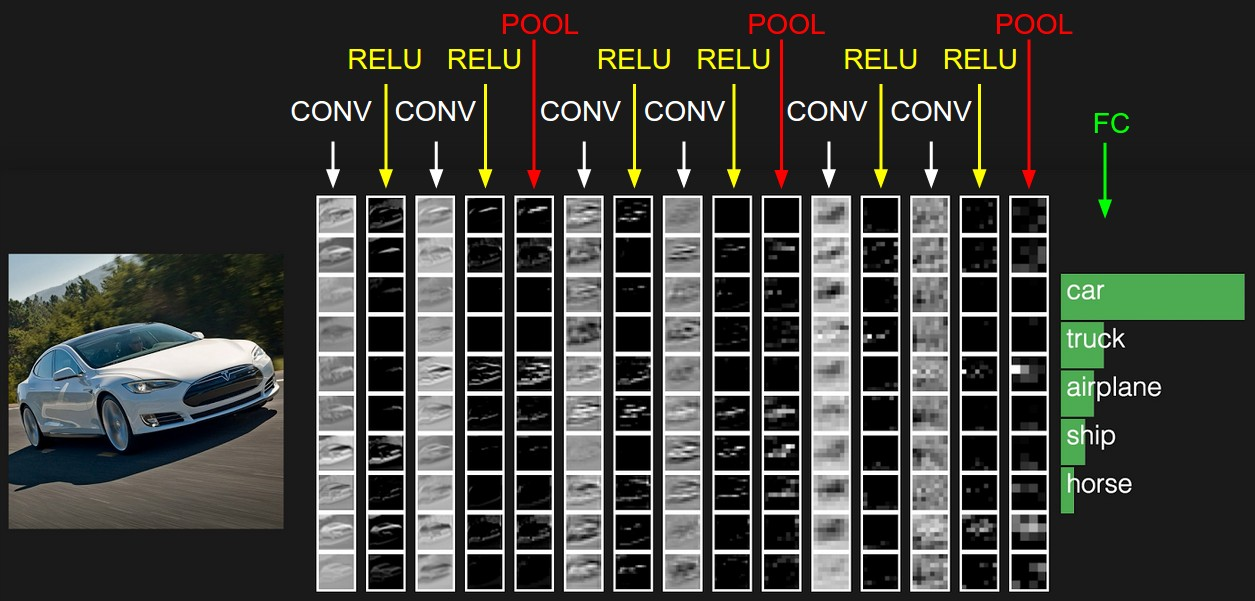

More Learning Resources:
http://cs231n.github.io/convolutional-networks/

http://ufldl.stanford.edu/tutorial/supervised/ConvolutionalNeuralNetwork/

https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks/

http://deeplearning.net/tutorial/lenet.html

https://medium.com/@ageitgey/machine-learning-is-fun-part-3-deep-learning-and-convolutional-neural-networks-f40359318721

In [49]:
#Creating Simple CNN model.
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(64, 64, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# the model so far outputs 3D feature maps( height, width, features)

#on top of it we stick two fully-connected layers. We end the model with a single model with a single unit
#and a sigmoid activation, which is perfect for a binary classification. To go with it we will also use 
#the binary_crossentropy 
#loss to train our model.

model.add(Flatten())   #this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))  #number of classes=2
#model.add(Activation('sigmoid'))
model.add(Activation('sigmoid'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

model.compile(loss='binary_crossentropy',
             optimizer=opt,
             metrics=['accuracy'])

In [50]:
X_train.shape

(10431, 64, 64, 3)

In [51]:
X_test.shape

(2608, 64, 64, 3)

In [52]:
batch_size = 24
history=model.fit_generator(
        datagen.flow(X_train, y_train),
        steps_per_epoch=10431 // batch_size,
        epochs=20,
        validation_data=datagen.flow(X_test, y_test),
        validation_steps=2608 // batch_size)

model.save_weights('Picasso_cnn.h5')

Epoch 1/20
434/434 [==============================] - 110s - loss: 1.7637 - acc: 0.6824 - val_loss: 0.5002 - val_acc: 0.7820
Epoch 2/20
434/434 [==============================] - 111s - loss: 0.5271 - acc: 0.7598 - val_loss: 0.4670 - val_acc: 0.8087
Epoch 3/20
434/434 [==============================] - 111s - loss: 0.4845 - acc: 0.7869 - val_loss: 0.4619 - val_acc: 0.8026
Epoch 4/20
434/434 [==============================] - 110s - loss: 0.4690 - acc: 0.7969 - val_loss: 0.4380 - val_acc: 0.8073
Epoch 5/20
434/434 [==============================] - 116s - loss: 0.4509 - acc: 0.7960 - val_loss: 0.4216 - val_acc: 0.8081
Epoch 6/20
434/434 [==============================] - 116s - loss: 0.4519 - acc: 0.8046 - val_loss: 0.4148 - val_acc: 0.8172
Epoch 7/20
434/434 [==============================] - 111s - loss: 0.4378 - acc: 0.8043 - val_loss: 0.4224 - val_acc: 0.8169
Epoch 8/20
434/434 [==============================] - 114s - loss: 0.4203 - acc: 0.8145 - val_loss: 0.4364 - val_acc: 0.8224


This approach gets us to a validation accuracy of 0.80-0.85 after 20 epochs (a number that was picked arbitrarily --because the model is small and uses aggressive dropout, it does not seem to be overfitting.

### Visualize Model Training History in Keras

The example collects the history, returned from training the model and creates two charts:

       1) A plot of accuracy on the training and validation datasets over training epochs.
       2) A plot of loss on the training and validation datasets over training epochs.

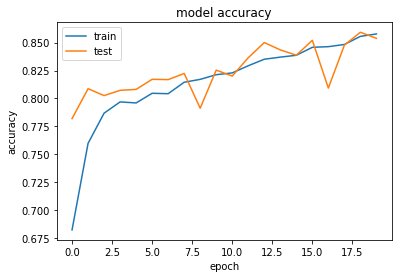

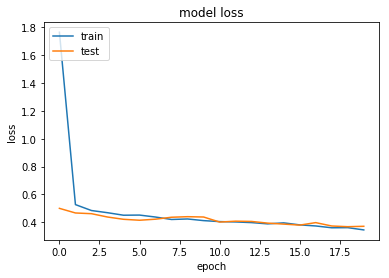

In [53]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()